# 实现一个class-conditioned扩散模型

在这个笔记中我们将展示如何向扩散模型中加入类别条件. 具体来说，我们将在MNIST上训练一个具备类别条件的扩散模型，使用的代码是['from-scratch' example in Unit 1](https://github.com/huggingface/diffusion-models-class/blob/unit2/unit1/02_diffusion_models_from_scratch.ipynb), 这样我们可以确定我们想要生成哪个数字。 

正如本单元介绍中提到的，这只是我们为扩散模型添加额外条件信息的许多方法之一，并因其相对简单而被选中。就像第一单元中的 "从头开始 "的笔记本一样，这个笔记本主要是为了说明问题，如果你愿意，你可以安全地跳过它。

## Setup and Data Prep

In [ ]:
!pip install -q diffusers

In [4]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'cuda:1'
print(f'Using device: {device}')

Using device: cuda:1


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([3, 9, 5, 9, 5, 3, 1, 6])


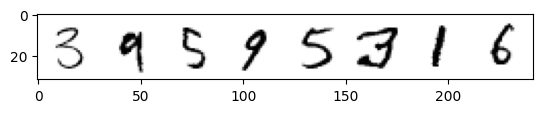

In [5]:
# Load the dataset
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## 创建 Class-Conditioned UNet

添加类别条件的方式如下：
- 创建 `UNet2DModel`，并添加额外的 input channels  
- 将类别标签 用一个embedding layer映射到 一个可学习的 向量， 形状= `(class_emb_size)`
- 将类别信息和原本的input concat到一起`net_input = torch.cat((x, class_cond), 1)`
- 将 `net_input` (which has (`class_emb_size+1`) channels in total) 输入 the unet 得到最终的预测

在这个例子中，我将class_emb_size设置为4，但这完全是任意的，你可以探索让它的大小为1（看是否仍然有效），大小为10（以匹配类的数量），或者直接用简单的类标签的单次编码来取代学习的nn.Embedding。

这就是实现的样子：

In [6]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    
    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64), 
        down_block_types=( 
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    
    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dinemsion (bs, class_emb_size=4)
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the unet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

如果有任何形状或变换令人困惑，可以加入打印语句来显示相关的形状，并检查它们是否符合你的期望。我还对一些中间变量的形状做了注释，希望能使事情更清楚。

In [7]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [8]:
#Training loop (10 Epochs):

# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network 
net = ClassConditionedUnet().to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        
        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.053961


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

Once training finishes, we can sample some images feeding in different labels as our conditioning:

0it [00:00, ?it/s]

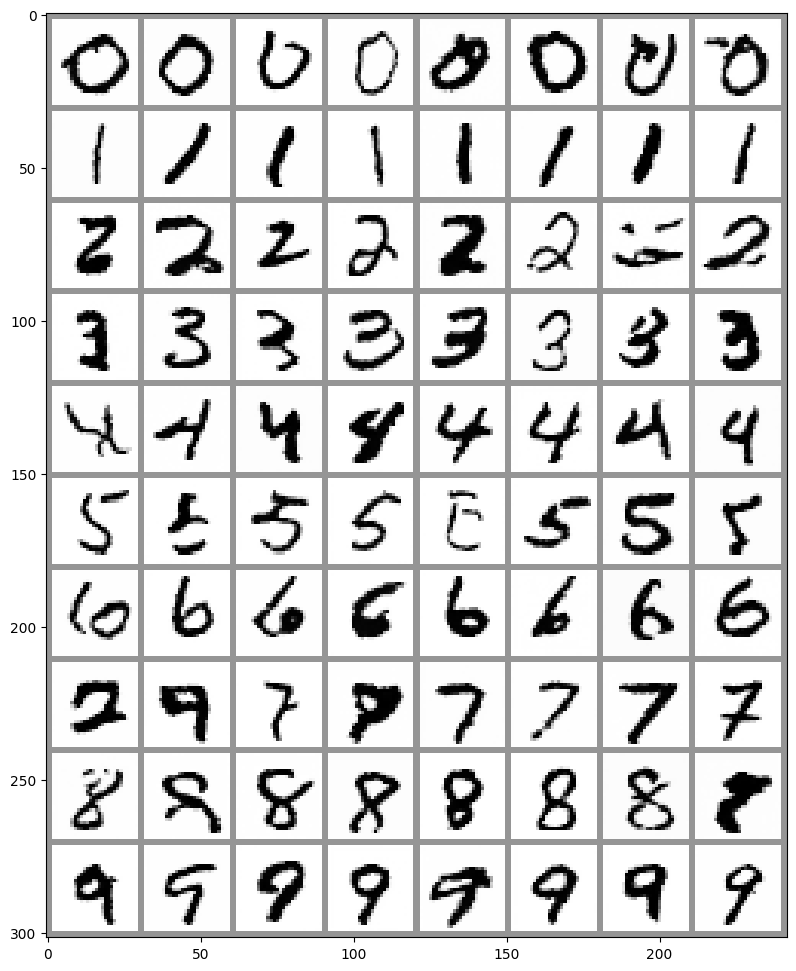

In [6]:
#@markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

There we go! We can now have some control over what images are produced.

I hope you've enjoyed this example. As always, feel free to ask questions in the Discord.

In [1]:
# Exercise (optional): Try this with FashionMNIST. Tweak the learning rate, batch size and number of epochs.
# Can you get some decet-looking fashion images with less training time than the example above?
from datasets import load_dataset
dataset = load_dataset("fashion_mnist", split='train')

Found cached dataset fashion_mnist (/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


In [45]:
# visualize some images
for n, i in enumerate(dataset):
    i['image'].show()
    if n > 0:
        break


In [2]:
from torchvision import transforms as T
batch_size = 128  
# scheduler.set_timesteps(num_inference_steps=40)
preprocess = T.Compose(
    [
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image) for image in examples["image"]]
    labels = [lbl for lbl in examples["label"]]
    return {"images": images,
            "labels": labels}

train_dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

dataset.set_transform(transform)
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"],nrow=16)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);
print(batch['labels'])




NameError: name 'DataLoader' is not defined

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.290930


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.215147


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.178100


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.155981


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.140280


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.130799


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.121310


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.116132


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.113907


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.110365


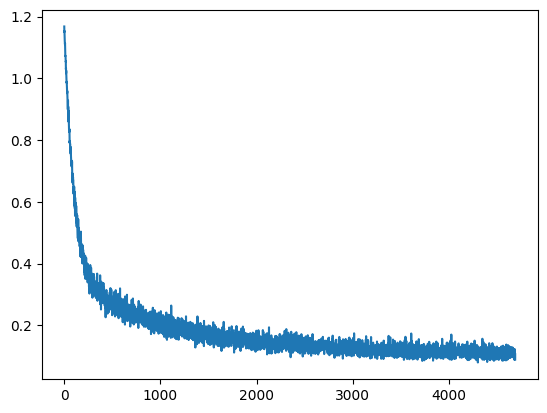

In [59]:
num_epochs = 10
lr = 1e-5
class_emb_size = 5
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
network = ClassConditionedUnet(num_classes=10,class_emb_size=class_emb_size).to(device)
optimizer = torch.optim.AdamW(network.parameters(), lr=lr)
loss_fn = nn.MSELoss()
losses = []
for epoch in range(num_epochs):
    for data in tqdm(train_dataloader):
        x = data['images'].to(device)
        y = data['labels'].to(device)



        noise = torch.randn_like(x)
        timesteps = torch.randint(0,999,(x.shape[0],), device=device).long()
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        pred = network(noisy_x, timesteps, y)
        loss = loss_fn(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

plt.plot(losses)

0it [00:00, ?it/s]

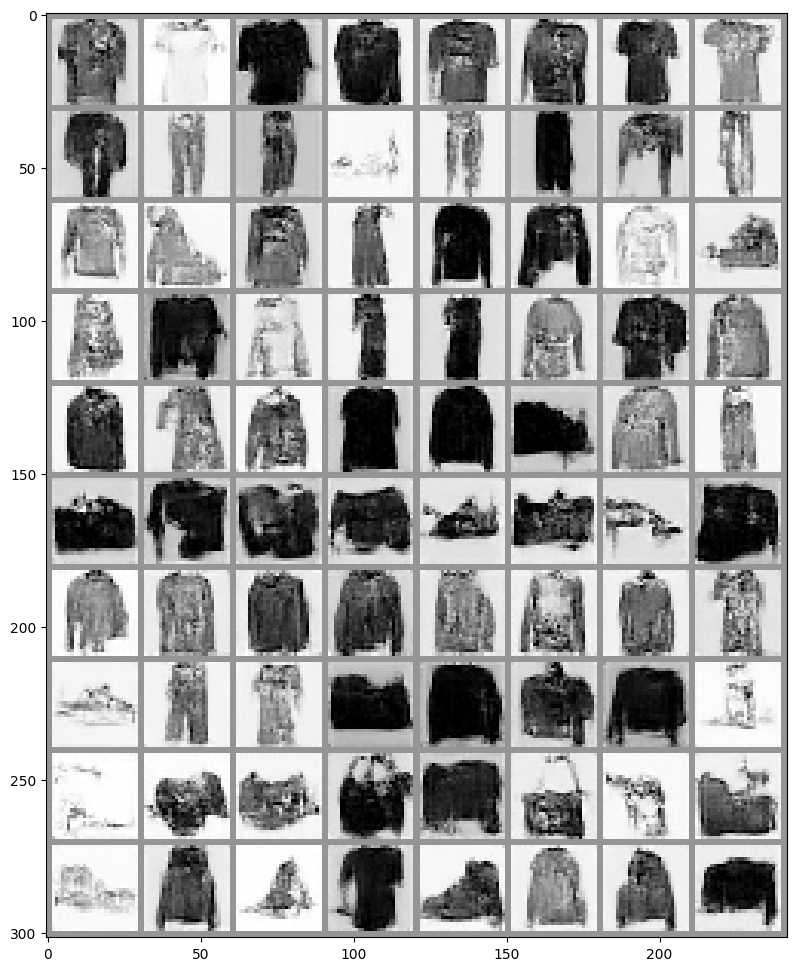

In [60]:
# generate samples
# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = network(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

有指导，但是不多，这个数据集比手写数字应该是要难不少
